# Alex Spence
# DSC 680 Project 2 Code

In [1]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder

os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
print("Setup complete")

Setup complete


In [2]:
# Download the dataset from Kaggle

df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(f"Raw data shape: {df.shape}")
df.head()

Raw data shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Cleaning and feature engineering
# Drop constant columns (these are always the same value)
df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], 
             axis=1, errors='ignore')

# Target: Attrition to binary (Yes → 1, No → 0)
df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)

# Label encode ordinal-ish categoricals
le = LabelEncoder()
for col in ['BusinessTravel', 'Department', 'EducationField', 'Gender', 
            'JobRole', 'MaritalStatus']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

# One-hot encode remaining categoricals (mainly OverTime)
df = pd.get_dummies(df, columns=['OverTime'], drop_first=True, dtype=int)

# Derived features
df['IncomeToTenureRatio'] = df['MonthlyIncome'] / (df['YearsAtCompany'] + 1)  # avoid div by zero
df['TotalSatisfaction'] = df[['EnvironmentSatisfaction', 'JobSatisfaction', 
                              'RelationshipSatisfaction']].mean(axis=1)
df['CommuteBurden'] = df['DistanceFromHome'] * df['BusinessTravel']  # rough proxy

# Final X/y
y = df['Attrition']
X = df.drop('Attrition', axis=1)

# Ensure all numeric
X = X.astype('float64')

print(f"Cleaned shape: {X.shape}, Attrition rate: {y.mean():.3%}")

Cleaned shape: (1470, 33), Attrition rate: 16.122%


In [5]:
# Train-test split and XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': (y_train == 0).sum() / y_train.sum()
}

model = xgb.train(params, dtrain, num_boost_round=300,
                  evals=[(dtest, 'test')], early_stopping_rounds=30, verbose_eval=False)

prob = model.predict(dtest)
auc = roc_auc_score(y_test, prob)
print(f"XGBoost AUC: {auc:.3f}")

joblib.dump(model, 'models/final_xgboost_model.pkl')

XGBoost AUC: 0.791


['models/final_xgboost_model.pkl']

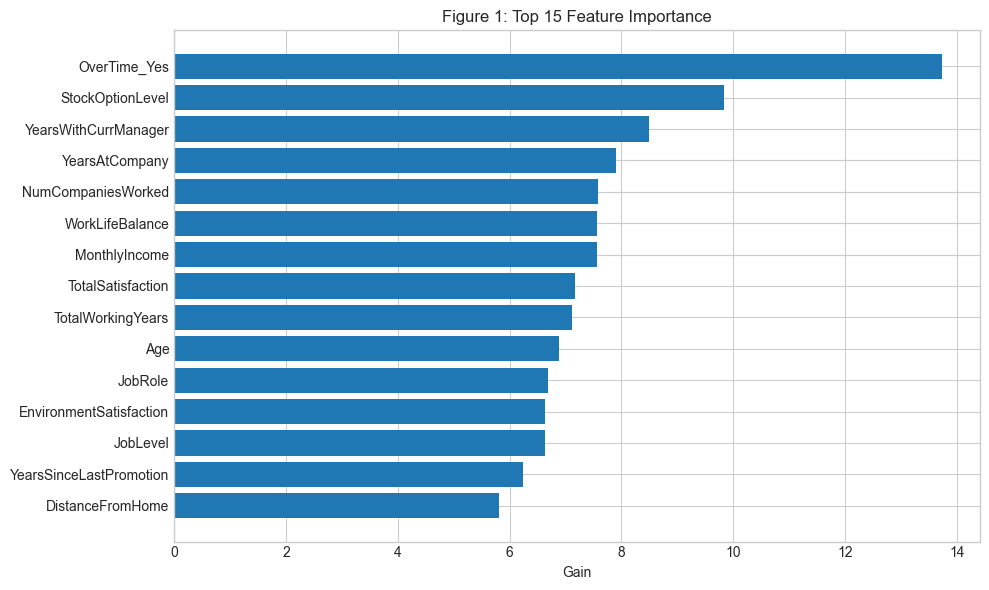

In [12]:
# 
# Figure 1: Feature Importance
imp = model.get_score(importance_type='gain')
top15 = sorted(imp.items(), key=lambda x: x[1], reverse=True)[:15]
feat, val = zip(*top15)

plt.barh(range(len(feat)), val)
plt.yticks(range(len(feat)), feat)
plt.gca().invert_yaxis()
plt.title('Figure 1: Top 15 Feature Importance')
plt.xlabel('Gain')
plt.tight_layout()
plt.savefig('figures/fig1_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

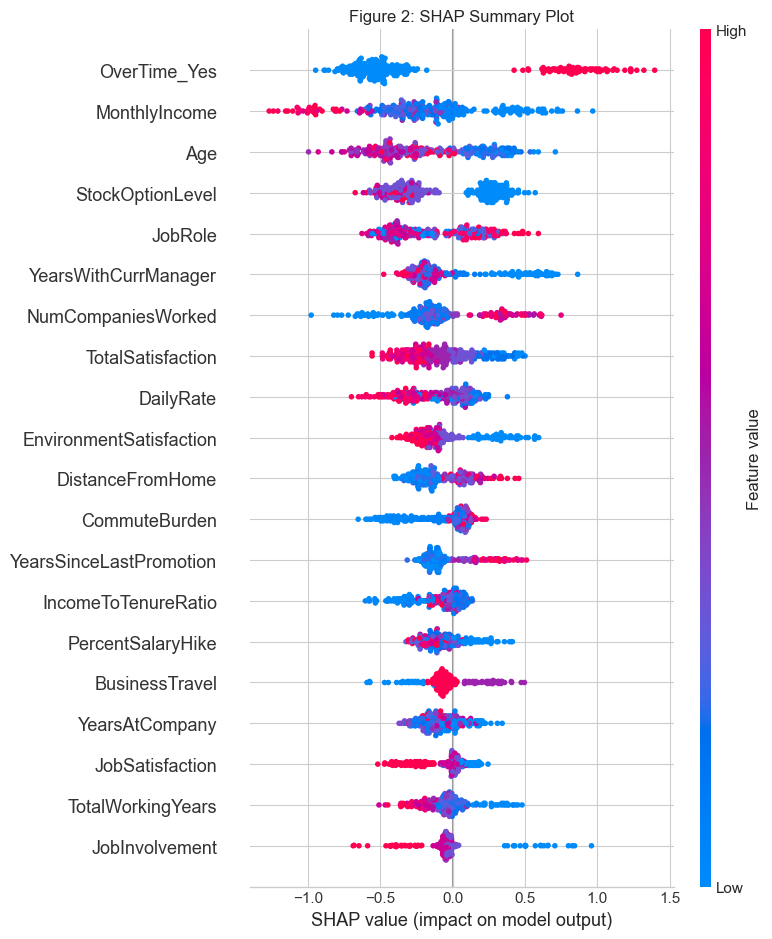

In [8]:
# Figure 2: SHAP Summary – use full test set (small enough)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)

shap.summary_plot(shap_vals, X_test, show=False)
plt.title('Figure 2: SHAP Summary Plot')
plt.tight_layout()
plt.savefig('figures/fig2_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

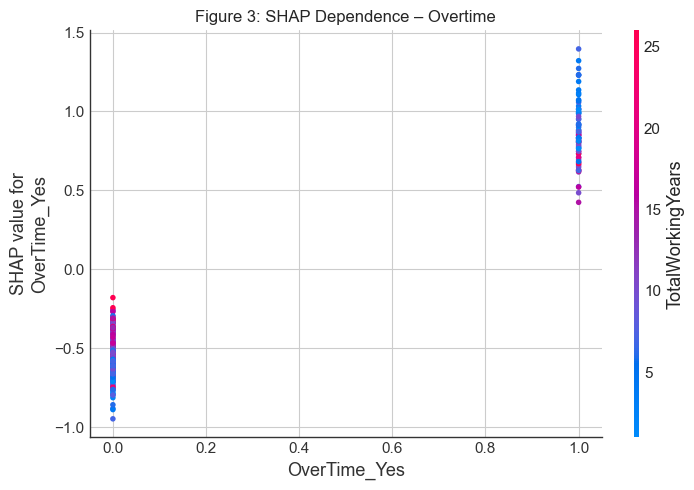

In [9]:
# Figure 3: SHAP Dependence for Overtime (top predictor)
# Use full X_test or same sample as above
shap.dependence_plot('OverTime_Yes', shap_vals, X_test, show=False)  # or use 'sample' if you kept subsampling
plt.title('Figure 3: SHAP Dependence – Overtime')
plt.tight_layout()
plt.savefig('figures/fig3_shap_dependence_overtime.png', dpi=300, bbox_inches='tight')
plt.show()

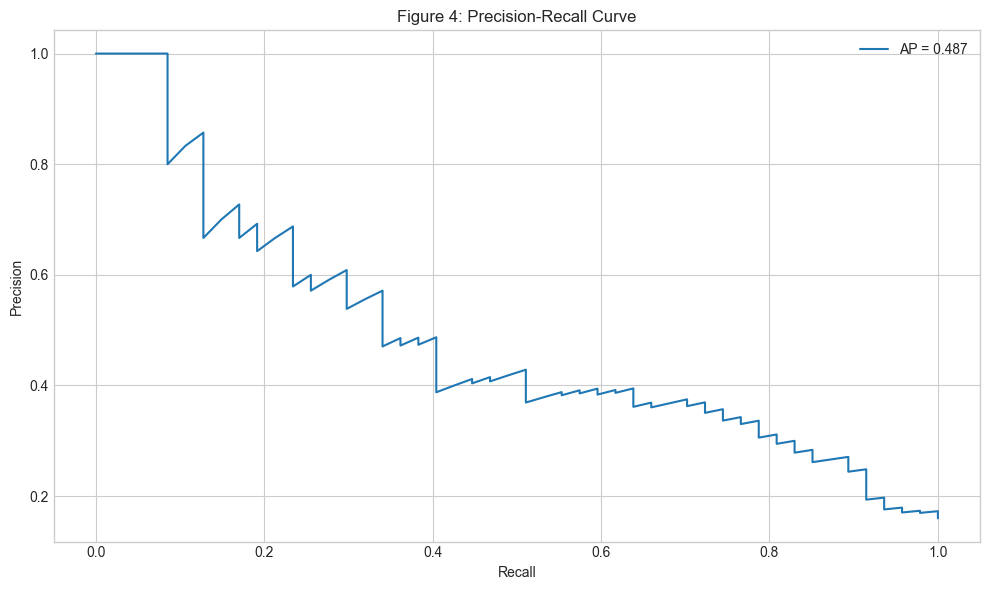

In [10]:
# Figure 4: Precision-Recall Curve
prec, rec, thresh = precision_recall_curve(y_test, prob)
ap = average_precision_score(y_test, prob)

plt.plot(rec, prec, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 4: Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/fig4_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Create Streamlit app for Figure 5
streamlit_code = """
import streamlit as st
import joblib
import xgboost as xgb
import pandas as pd

st.title("Employee Attrition Risk Calculator")

model = joblib.load('models/final_xgboost_model.pkl')

st.write("Enter employee details below:")

overtime = st.checkbox("Works Overtime", value=False)
satisfaction = st.slider("Overall Job Satisfaction (1–4)", 1, 4, 3)
income = st.number_input("Monthly Income ($)", 1000, 20000, 5000)
distance = st.slider("Distance from Home (miles)", 1, 30, 10)
years_promotion = st.slider("Years Since Last Promotion", 0, 15, 2)

# Create input row with defaults
input_data = pd.DataFrame(0.0, index=[0], columns=model.feature_names)
input_data['OverTime_Yes'] = int(overtime)
input_data['JobSatisfaction'] = satisfaction  # proxy for overall
input_data['MonthlyIncome'] = income
input_data['DistanceFromHome'] = distance
input_data['YearsSinceLastPromotion'] = years_promotion

dmat = xgb.DMatrix(input_data)
prob = model.predict(dmat)[0]
risk = prob * 100

st.metric("Predicted Attrition Risk", f"{risk:.1f}%")

if risk > 40:
    st.error("HIGH RISK — urgent manager discussion recommended")
elif risk > 20:
    st.warning("Elevated risk — consider career conversation")
else:
    st.success("Low risk")
"""

with open('streamlit_app.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app created!")
print("To get Figure 5:")
print("1. Run: streamlit run streamlit_app.py")
print("2. Try high-risk inputs (e.g., overtime=yes, satisfaction=1, income=low)")
print("3. Screenshot the page")
print("4. Save as figures/fig5_streamlit_demo.png")

Streamlit app created!
To get Figure 5:
1. Run: streamlit run streamlit_app.py
2. Try high-risk inputs (e.g., overtime=yes, satisfaction=1, income=low)
3. Screenshot the page
4. Save as figures/fig5_streamlit_demo.png
